In [1]:
import os, sys

import numpy as np
from scipy.linalg import eigh
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt
import scipy.linalg as sla
import pandas as pd
import numpy as np
from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from shapely.geometry.polygon import LinearRing

from astropy.io import fits
from astropy import wcs
from matplotlib import cm
from matplotlib.colors import LogNorm

import warnings
warnings.filterwarnings('ignore')

from sbfTools import *

In [2]:
#https://math.stackexchange.com/questions/1114879/detect-if-two-ellipses-intersect

## Object Initialization

In [3]:
# obj = ellOBJ("n0679", outFolder="Outputs_n0679")
# obj = ellOBJ("u12517", outFolder="Outputs_u12517")
# obj = ellOBJ("n0439", outFolder="Outputs_n0439")

# obj = ellOBJ("n6577", outFolder="Outputs_n6577", inFolder='/media/Data/Home/PanStarrs/Jan/HI/augment/SBF/wfc3-16262')

# obj = ellOBJ("n3308", outFolder="Outputs_n3308", inFolder='/media/Data/Home/PanStarrs/Jan/HI/augment/SBF/wfc3-16262')

# obj = ellOBJ("n7265", outFolder="Outputs_n7265", inFolder='/media/Data/Home/PanStarrs/Jan/HI/augment/SBF/wfc3-16262')

# bright nearby object
# obj = ellOBJ("n3268", outFolder="Outputs_n3268", inFolder='/media/Data/Home/PanStarrs/Jan/HI/augment/SBF/wfc3-16262')


### Spiral arms, reject
# obj = ellOBJ("n6688", outFolder="Outputs_n6688", inFolder='/media/Data/Home/PanStarrs/Jan/HI/augment/SBF/wfc3-16262')

## nuclear dust + companion
obj = ellOBJ("n4825", outFolder="Outputs_n4825", inFolder='/media/Data/Home/PanStarrs/Jan/HI/augment/SBF/wfc3-16262')


In [4]:
obj.sky_med, obj.x0, obj.y0

(3614.433837890625, 566.689, 549.927)

In [5]:
obj.x_max, obj.y_max

(1022, 1025)

In [6]:
r = min([obj.x0, obj.x_max-obj.x0, obj.y0, obj.y_max-obj.y0])

r, int(obj.r_max)

(455.31100000000004, 455)

Back Median: 3614.43
Back Mean: 3634.30
Back Stdev: 258.12


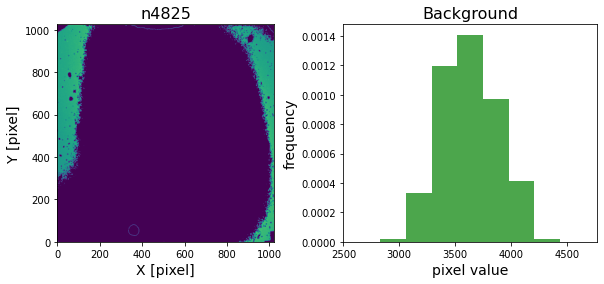

In [7]:
ax1, ax2 = obj.plot_background()

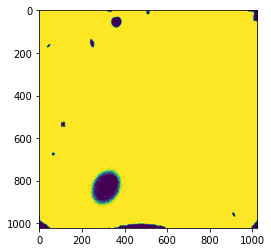

In [8]:
im, mask = obj.naive_Sextract(minArea=100, thresh=1.5, mask=0)
## plot_2darray(mask)
obj.addMasks(maskList=[0], mask=1)
im, h = obj.maskOpen(mask=1)
plt.imshow(im)

N_cross: 0
r0: 3
r1: 259
nr: 17
sky: 3252
CPU times: user 668 ms, sys: 316 ms, total: 984 ms
Wall time: 908 ms


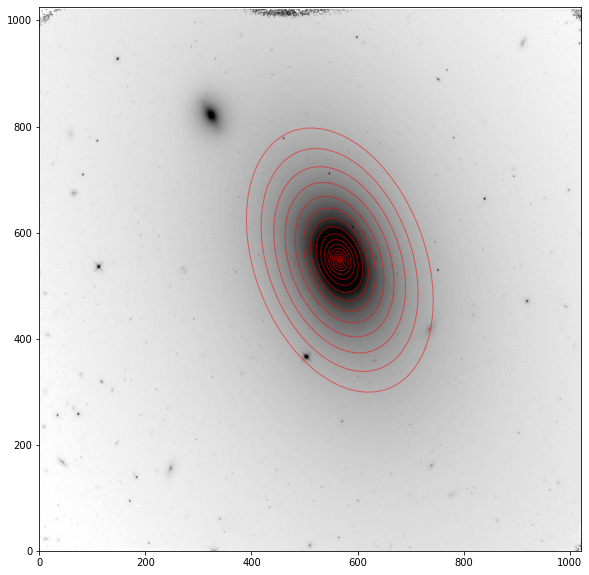

In [9]:
%%time

r0 = 3              # pixel
c_kron = 2      # Kron radius factor
k = 15 
sky_factor = 0.9    # always less than one

r1 = obj.outerR(c_kron)
nr = int(np.round(r1/k))
sky = int(sky_factor*obj.sky_med)

msg = obj.elliprof(r0, r1, nr=nr, sky=sky, niter=10, options="", mask=1)

n_cross = Xellipses(obj.list_ellipses(model=0))
        
ax = obj.tv(options="sqrt")
ax = obj.plot_ellipse(model=0, ax=ax, alpha=0.5, linewidth=1, edgecolor='r', facecolor='none')

print("N_cross: %d"%n_cross)
print("r0: %d"%r0)
print("r1: %d"%r1)
print("nr: %d"%nr)
print("sky: %d"%sky)

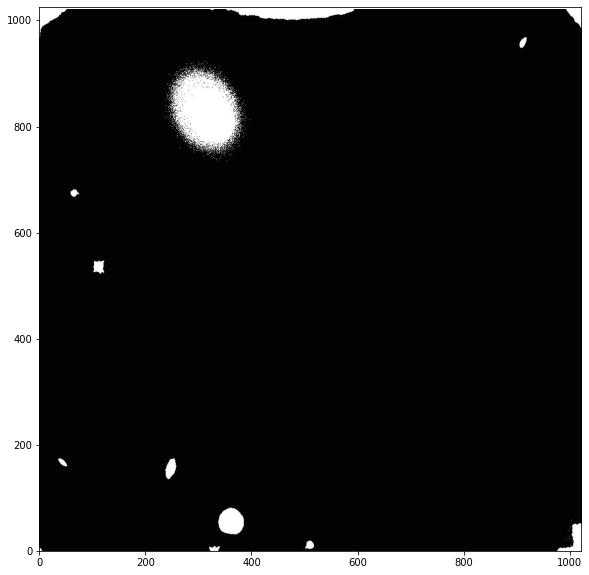

In [10]:
obj.tv_mask(mask=1)

sex Outputs_n4825//tmp -c wfc3j.inpar -CHECKIMAGE_NAME Outputs_n4825//objCheck.000 -CATALOG_NAME  Outputs_n4825//objCatal.000 -DETECT_MINAREA 500 -DETECT_THRESH 5 -WEIGHT_IMAGE  Outputs_n4825//model.000


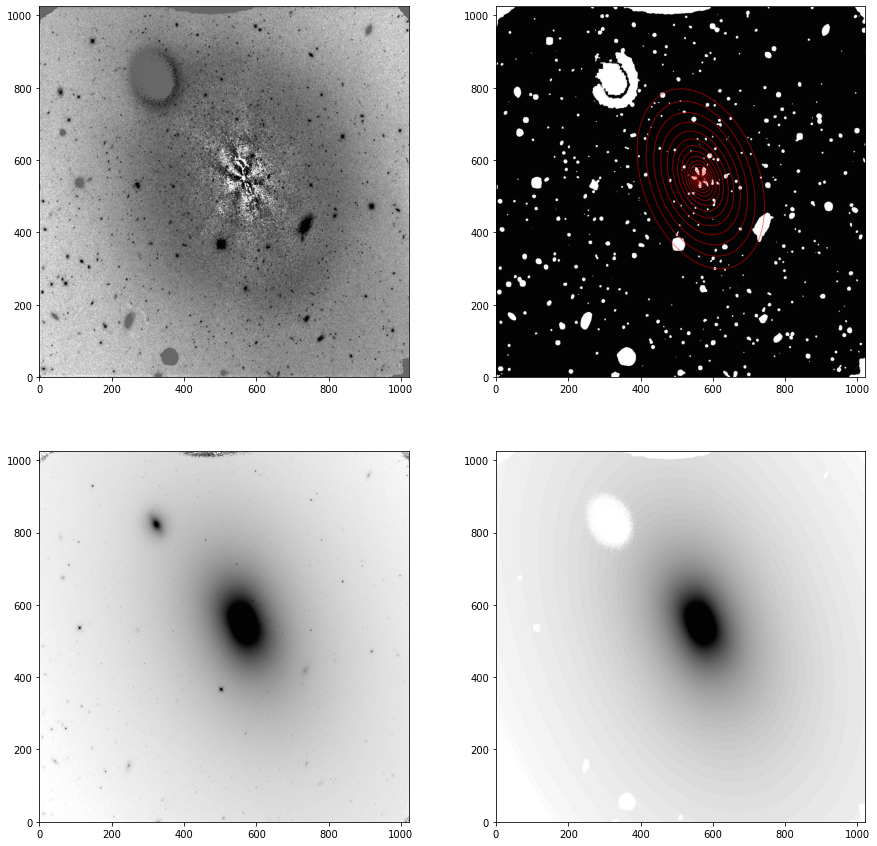

In [11]:
r0 = 7
r1 = obj.outerR(2)
nr = int(np.round(r1/15))
sky_factor = 0.85    # always less than one
   
# using common mask --> model 0 
obj.elliprof(r0, r1, nr=nr, sky=obj.sky_med, niter=10, mask=1)

# using residuals of model 0 --> mask 0
obj.objSEextract(model=0, smooth=4, minArea=500, thresh=5, mask=2) 

# plotting model 0

fig, ax = plt.subplots(2, 2, figsize=(15,15))

obj.tv_resid(model=0, ax = ax[0][0], options='sqrt')
obj.tv_mask(mask=2, ax = ax[0][1])
obj.plot_ellipse(model=0, ax=ax[0][1], alpha=0.5, linewidth=1, edgecolor='r', facecolor='none')


obj.tv(ax = ax[1][0], options='sqrt')
obj.tv_model(model=0, ax=ax[1,1], options='sqrt')

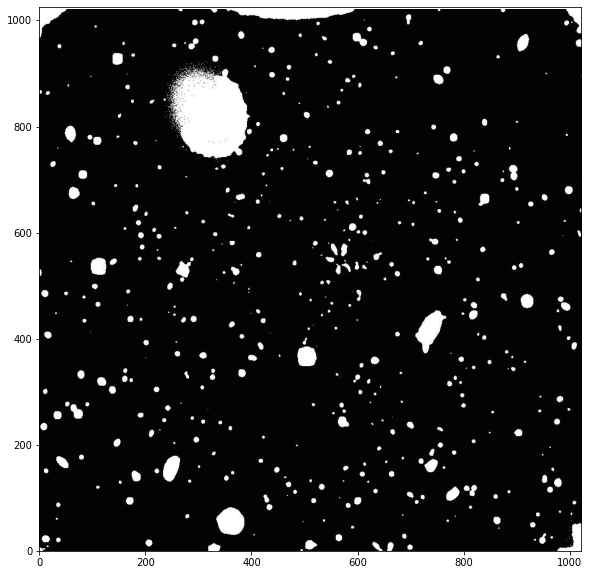

In [12]:
obj.addMasks(maskList=[1,2], mask=3)

obj.tv_mask(mask=3)

sex Outputs_n4825//tmp -c wfc3j.inpar -CHECKIMAGE_NAME Outputs_n4825//objCheck.000 -CATALOG_NAME  Outputs_n4825//objCatal.000 -DETECT_MINAREA 500 -DETECT_THRESH 5 -WEIGHT_IMAGE  Outputs_n4825//model.000


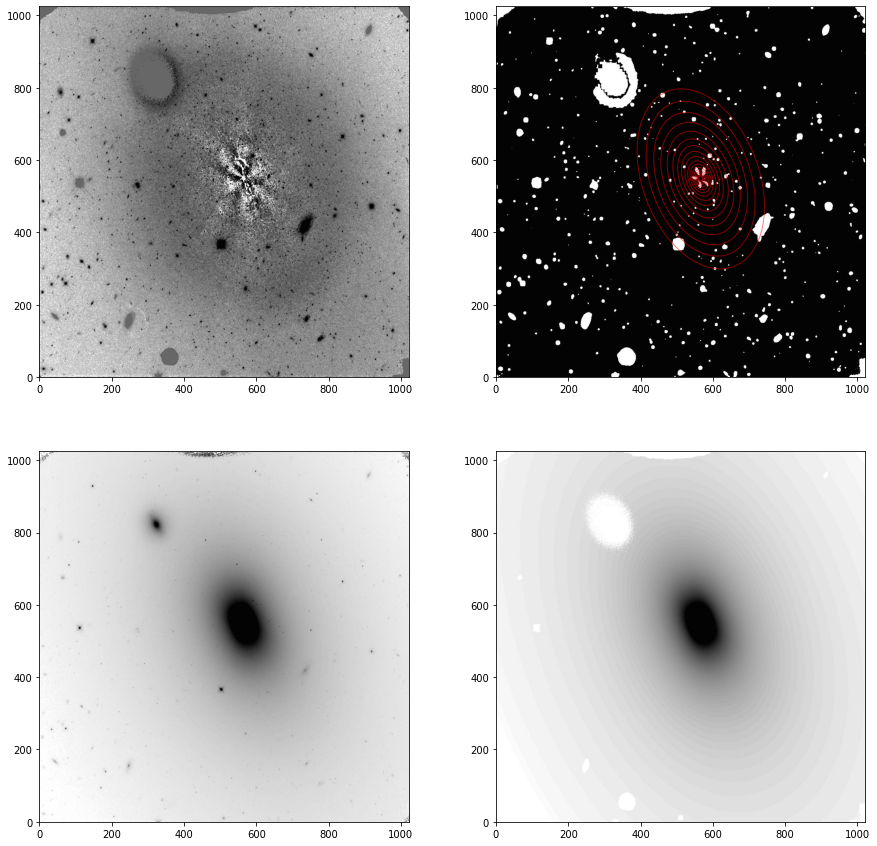

In [13]:
r0 = 7
r1 = obj.outerR(4)
nr = int(np.round(r1/15))
sky_factor = 0.94    # always less than one
   
# using common mask --> model 0 
obj.elliprof(r0, r1, nr=nr, sky=obj.sky_med, niter=10, mask=3)

# using residuals of model 0 --> mask 0
obj.objSEextract(model=0, smooth=3, minArea=70, thresh=5, mask=4) 

# plotting model 0

fig, ax = plt.subplots(2, 2, figsize=(15,15))

obj.tv_resid(model=0, ax = ax[0][0], options='sqrt')
obj.tv_mask(mask=4, ax = ax[0][1])
obj.plot_ellipse(model=0, ax=ax[0][1], alpha=0.5, linewidth=1, edgecolor='r', facecolor='none')


obj.tv(ax = ax[1][0], options='sqrt')
obj.tv_model(model=0, ax=ax[1,1], options='sqrt')

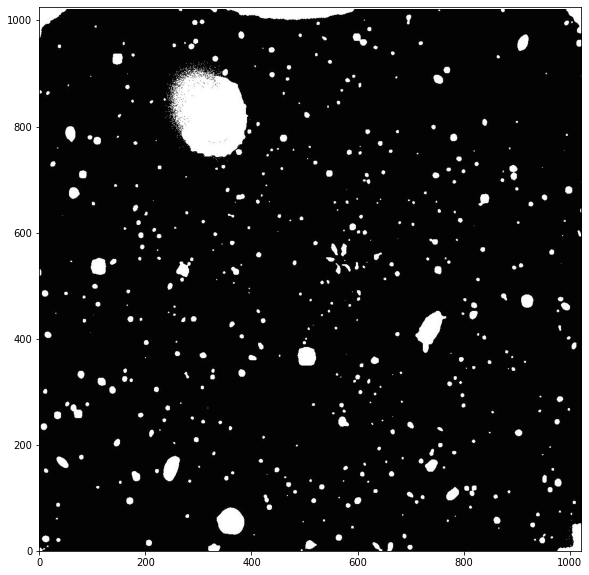

In [14]:
obj.addMasks(maskList=[1,4], mask=5)

obj.tv_mask(mask=5)

sex Outputs_n4825//tmp -c wfc3j.inpar -CHECKIMAGE_NAME Outputs_n4825//objCheck.000 -CATALOG_NAME  Outputs_n4825//objCatal.000 -DETECT_MINAREA 500 -DETECT_THRESH 3 -WEIGHT_IMAGE  Outputs_n4825//model.000


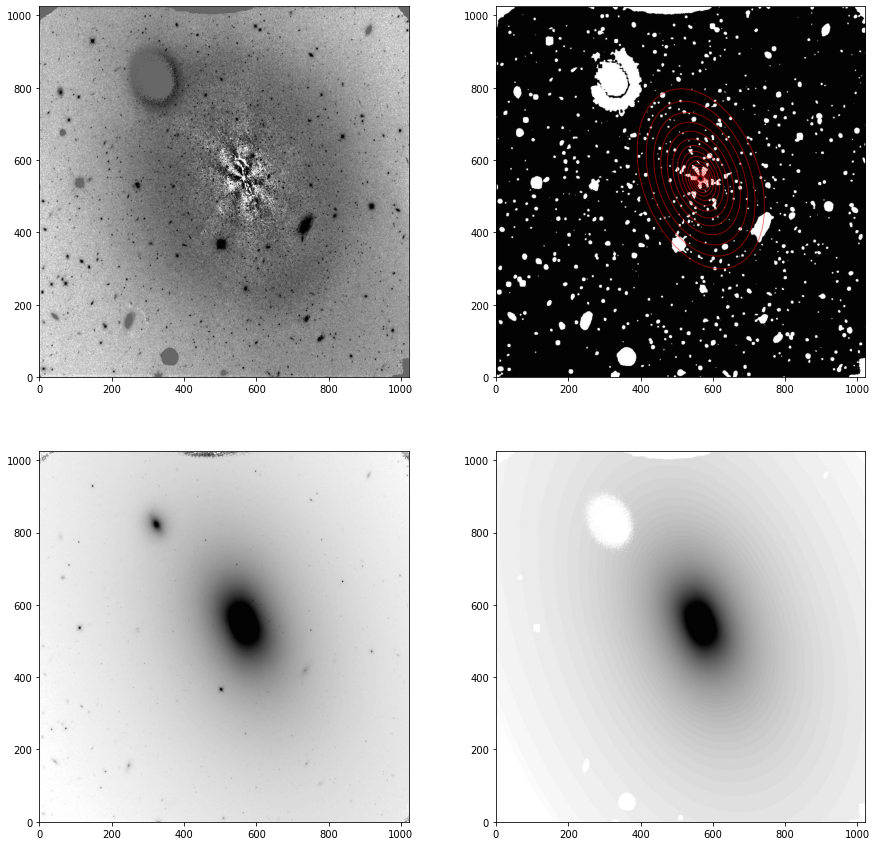

In [15]:
r0 = 7
r1 = obj.outerR(4)
nr = int(np.round(r1/15))
sky_factor = 0.94    # always less than one
   
# using common mask --> model 0 
obj.elliprof(r0, r1, nr=nr, sky=obj.sky_med, niter=10, mask=5)

# using residuals of model 0 --> mask 0
obj.objSEextract(model=0, smooth=3, minArea=0, thresh=3, mask=6) 

# plotting model 0

fig, ax = plt.subplots(2, 2, figsize=(15,15))

obj.tv_resid(model=0, ax = ax[0][0], options='sqrt')
obj.tv_mask(mask=6, ax = ax[0][1])
obj.plot_ellipse(model=0, ax=ax[0][1], alpha=0.5, linewidth=1, edgecolor='r', facecolor='none')


obj.tv(ax = ax[1][0], options='sqrt')
obj.tv_model(model=0, ax=ax[1,1], options='sqrt')

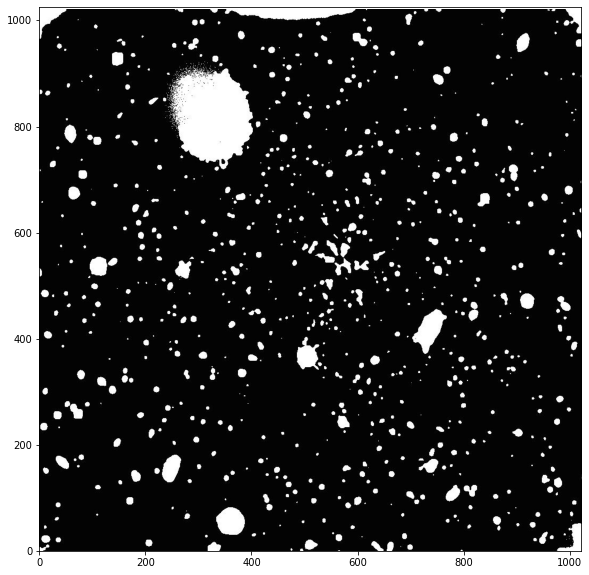

In [16]:
obj.addMasks(maskList=[1,6], mask=7)

obj.tv_mask(mask=7)

In [21]:
def get_RMS(r0, r1, nr, sky_factor):
    
    sky = int(sky_factor*obj.sky_med)
    n_cross = 0
    
    if obj.elliprof(r0, r1, nr=nr, sky=sky, niter=10, mask=0, model=1) != 'OK':
        n_cross+=1
        
#     obj.objSEextract(model=0, smooth=5, minArea=20, thresh=5) 
#     if obj.elliprof(r0, r1, nr=nr, sky=sky, niter=10, mask=0, model=1) != 'OK':
#         n_cross+=1
    
    n_cross += Xellipses(obj.list_ellipses(model=1))
    model = 1
    root = obj.objRoot
    suffix = '.%03d'%model

    ellipseFile = root+'/elliprof'+suffix
    df = pd.read_csv(ellipseFile, delimiter=r"\s+", skiprows=7)
    df = df.apply(pd.to_numeric, errors='coerce')
    x = df.Rmaj**0.25
    y = 2.5*np.log10(df.I0)

    maxX = np.max(x)
    minX = np.min(x)
    dx = maxX-minX
    x1 = 0.40*dx+minX
    x2 = maxX-0.20*dx
    x3 = maxX-0.10*dx
    x0 = x[((x<x2) & (x>x1))]
    y0 = y[((x<x2) & (x>x1))]

    m, b = np.polyfit(x0, y0, 1)

    x_data = x[((x>=x3))]
    y_data = y[((x>=x3))]
    y_model = m*x_data+b

    rms = np.sqrt(np.mean((y_data.values-y_model.values)**2))
    
    return rms, n_cross

In [22]:
from scipy import optimize
from scipy.optimize import minimize

def f(sky_factor):
    
    r0 = 7
    r1 = int(4.0*np.sqrt(obj.a*obj.b))
    nr = int(np.round(r1/15))
    rms, n_cross = get_RMS(r0, r1, nr, sky_factor)
   
   
    sig = rms 
    
    if sig>10 or np.isnan(sig) or n_cross>0:
        sig = 10
    
    return -sig


In [23]:
from bayes_opt import BayesianOptimization
### https://github.com/fmfn/BayesianOptimization

# Bounded region of parameter space
pbounds = {'sky_factor': (0.65, 1.05)}

optimizer = BayesianOptimization(
    f=f,
    pbounds=pbounds,
    random_state=1,
)

In [24]:
%%time

optimizer.maximize(
    init_points=3,
    n_iter=15,
)

|   iter    |  target   | sky_fa... |
-------------------------------------
|  1        | -0.1228   |  0.8168   |
|  2        | -0.01029  |  0.9381   |
|  3        | -0.2357   |  0.65     |
|  4        | -0.1581   |  1.05     |
|  5        | -0.1245   |  0.8169   |
|  6        | -0.01321  |  0.9354   |
|  7        | -0.01789  |  0.9439   |
|  8        | -0.1317   |  0.8083   |
|  9        | -0.0229   |  0.9497   |
|  10       | -0.02951  |  0.9566   |
|  11       | -0.02117  |  0.9279   |
|  12       | -0.02047  |  0.9204   |
|  13       | -0.0312   |  0.9127   |
|  14       | -0.03589  |  0.9652   |
|  15       | -0.03856  |  0.9041   |
|  16       | -0.05114  |  0.9739   |
|  17       | -0.04219  |  0.8953   |
|  18       | -0.05394  |  0.8864   |
CPU times: user 29 s, sys: 12.1 s, total: 41.1 s
Wall time: 29.2 s


In [25]:
print(optimizer.max)

{'target': -0.010291951844898601, 'params': {'sky_factor': 0.9381297973768632}}


In [ ]:
# %%time 

# result = optimize.minimize_scalar(f, bounds=(0.65, 1.1))

# result

In [ ]:
# r0 = 7
# r1 = int(5.0*np.sqrt(obj.a*obj.b))
# nr = int(np.round(r1/15))
# sky_factor = 1.1    # always less than one
# sky = int(sky_factor*obj.sky_med)

# rms_f = 1000
# sky_f = 10

# rms_l0 = []
# sky_l0 = []

# for sky_factor in np.arange(0.6, 1.06, 0.025):
#     sky = int(sky_factor*obj.sky_med)
    
#     obj.elliprof(r0, r1, nr=nr, sky=sky, niter=10)
#     n_cross = Xellipses(obj.list_ellipses(model=0))
#     model = 0
#     root = obj.objRoot
#     suffix = '.%03d'%model

#     ellipseFile = root+'/elliprof'+suffix
#     df = pd.read_csv(ellipseFile, delimiter=r"\s+", skiprows=7)
#     df = df.apply(pd.to_numeric, errors='coerce')
#     x = df.Rmaj**0.25
#     y = 2.5*np.log10(df.I0)

#     maxX = np.max(x)
#     minX = np.min(x)
#     dx = maxX-minX
#     x1 = 0.40*dx+minX
#     x2 = maxX-0.20*dx
#     x0 = x[((x<x2) & (x>x1))]
#     y0 = y[((x<x2) & (x>x1))]
#     ax.plot(x0, y0, 'ko', mfc='white')

#     m, b = np.polyfit(x0, y0, 1)

#     x_data = x[((x>=x2))]
#     y_data = y[((x>=x2))]
#     y_model = m*x_data+b

#     rms = np.sqrt(np.mean((y_data.values-y_model.values)**2))
    
#     print(sky_factor, rms, n_cross)

#     if rms < rms_f and n_cross==0:
#         rms_f = rms
#         sky_f = sky_factor
        
#     if n_cross == 0:
#         sky_l0.append(sky_factor)
#         rms_l0.append(rms)
    
    

In [ ]:
# plt.plot(sky_l, rms_l, '.')
# plt.plot(sky_l0, rms_l0, 'r.')

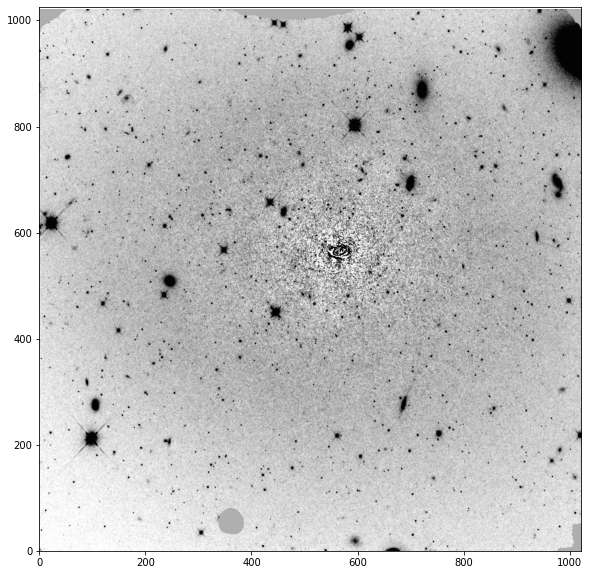

In [26]:
obj.tv_resid(model=0)

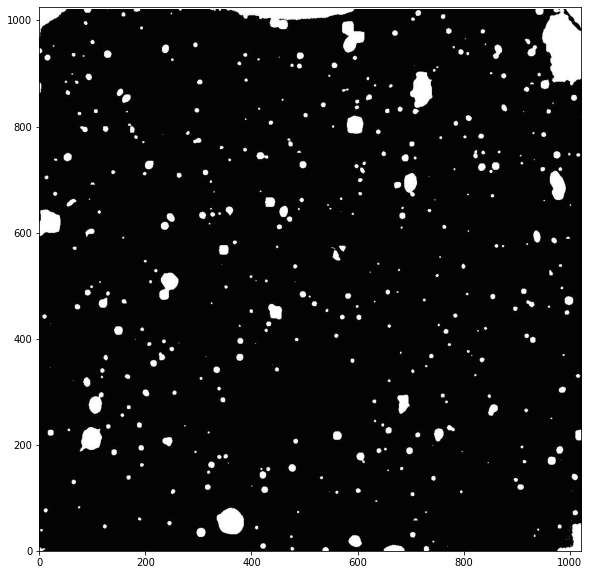

In [27]:
obj.tv_mask(mask=2)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f66d43fe8e0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f66d38a17c0>)

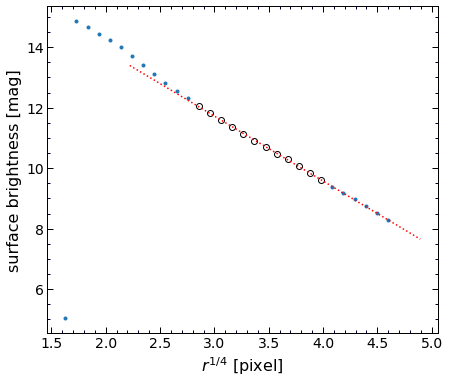

In [30]:
r0 = 7
r1 = int(4*np.sqrt(obj.a*obj.b))
nr = int(np.round(r1/15))
sky_factor = 0.93 # always less than one
sky = int(sky_factor*obj.sky_med)


# using common mask --> model 0 
obj.elliprof(r0, r1, nr=nr, sky=sky, niter=10)

# using mask 0 --> model 1 
obj.elliprof(r0, r1, nr=nr, sky=sky, niter=10, mask=0, model=1)


model = 1
root = obj.objRoot
suffix = '.%03d'%model

ellipseFile = root+'/elliprof'+suffix
df = pd.read_csv(ellipseFile, delimiter=r"\s+", skiprows=7)
df = df.apply(pd.to_numeric, errors='coerce')


fig, ax = plt.subplots(1,1, figsize=(7,6))

x = df.Rmaj**0.25
y = 2.5*np.log10(df.I0)
ax.plot(x, y, '.')

ax.set_xlabel(r"$r^{1/4}$"+" [pixel]", fontsize=16)
ax.set_ylabel(r"surface brightness"+" [mag]", fontsize=16)

maxX = np.max(x)
minX = np.min(x)
dx = maxX-minX
x1 = 0.40*dx+minX
x2 = maxX-0.20*dx
x0 = x[((x<x2) & (x>x1))]
y0 = y[((x<x2) & (x>x1))]
ax.plot(x0, y0, 'ko', mfc='white')

m, b = np.polyfit(x0, y0, 1)

xrange = np.linspace(x1-0.2*dx, maxX+0.1*dx, 100)
yrange = m*xrange+b

ax.plot(xrange, yrange, 'r:')


set_axes(ax, fontsize=14)

0

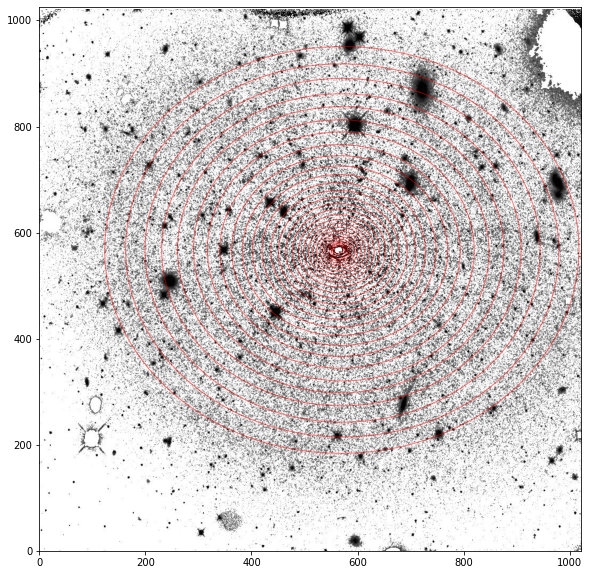

In [31]:
ax = obj.tv_resid(model=1, options='log')
ax = obj.plot_ellipse(model=1, ax=ax, alpha=0.5, linewidth=1, edgecolor='r', facecolor='none')

Xellipses(obj.list_ellipses(model=1))

In [ ]:

resid_name = obj.objRoot+"resid.001"
back_mask = obj.objRoot+"back_mask.fits"

imarray, header = imOpen(resid_name)
mskarray, header = imOpen(back_mask)

masked_image = imarray*mskarray

fits.writeto('./tmp.fits', np.float32(masked_image), overwrite=True)

## plot_2darray(imarray)
# tv('./tmp.fits', options='log')


a = masked_image
a = a[(a!=0)]
median = np.median(a)
mean = np.mean(a)
std = np.std(a)

print("Back Median: %.2f"%median)
print("Back Mean: %.2f"%mean)
print("Back Stdev: %.2f"%std)

plt.hist(a, bins=np.linspace(mean-4*std, mean+4*std, 10), density=True, color='g', alpha=0.7)

In [ ]:
tv(obj.objRoot+"back_mask.fits")

In [ ]:
sky_factor

In [ ]:
%%time

t_indx = 100
indlst = []

for c_kron in np.arange(3, 6, 1):
        for r0 in range(7,11,2):
            for opt in ['', 'COS3X=0','COS3X=1','COS3X=2','COS4X=0','COS4X=1','COS4X=2','COS6X=0','COS6X=-1','COS6X=-2']:
    
                r1 = int(c_kron*np.sqrt(obj.a*obj.b))
                nr = int(np.round(r1/20))
                sky = int(sky_factor*obj.sky_med)


                # generates model 0, using common mask
                if obj.elliprof(r0, r1, nr=nr, sky=sky, niter=10, options=opt) != 'OK':
                    print("Err1: ", t_indx, r0, r1, nr, sky_factor, c_kron)
                    t_indx+=1
                    continue

                n_cross = Xellipses(obj.list_ellipses(model=0))
                if n_cross>0:
                    print("N_cross 1: ", n_cross, t_indx, r0, r1, nr, k, sky_factor, c_kron, opt)
                    t_indx+=1
                    continue

                # usese residuals of model 0, generates mask t
                obj.objSEextract(model=0, smooth=10, minArea=20, thresh=5, mask=t_indx)

                ## generates model t, uses mask t      
                if obj.elliprof(r0, r1, nr=nr, mask=t_indx, model=t_indx, niter=10, sky=sky, options=opt)  != 'OK':
                    print("Err2: ", t_indx, r0, r1, nr, sky_factor, c_kron, opt)
                    t_indx+=1
                    continue

                n_cross = Xellipses(obj.list_ellipses(model=t_indx))
                if n_cross>0:
                    print("N_cross 2: ", n_cross, t_indx, r0, r1, nr, sky_factor, c_kron, opt)
                    t_indx+=1
                    continue

            #     print(t_indx)
                indlst.append(t_indx)
                t_indx+=1


In [ ]:
print(indlst)

In [ ]:
len(indlst)

In [ ]:
outFolder = 'Outputs_'+obj.name+'/'

In [ ]:
%%time

IM = None
for idx in indlst:
    suffix = '.%03d'%idx
    mask_name = "mask"+suffix
    
    im, header = maksOpen(outFolder+mask_name)
    im = np.abs(im-1)
    
    if IM is None:
        IM = im
    else:
        IM = IM+im

IM /= len(indlst)
IM[IM>=0.99] = 1
IM[IM<0.99] = 0

IM = np.abs(IM-1)      
plt.imshow(IM, cmap=plt.get_cmap('gray'))


In [ ]:
fits.writeto(outFolder+'mask.super.fits', IM, header, overwrite=True)

In [ ]:
name = obj.name
segment = outFolder+'segment.fits'
objCatal = outFolder+'catal.cat'
objname = "{}/{}j.fits".format(name,name)
sex_cmd = """sex """+objname+""" -c wfc3j.inpar -CHECKIMAGE_TYPE SEGMENTATION -CHECKIMAGE_NAME """+segment
sex_cmd += " -CATALOG_NAME  "+objCatal
sex_cmd += " -DETECT_MINAREA 10"
sex_cmd += " -DETECT_THRESH 2"
sex_cmd += " -WEIGHT_TYPE NONE"
xcmd(sex_cmd, True)
#######################################
im, _ = imOpen(segment)
im[im<=1] = 1
im[im>1] = 0
IM_ = IM * im
plt.imshow(IM, cmap=plt.get_cmap('gray'))
fits.writeto(outFolder+'mask.super.fits', np.float32(IM_), header, overwrite=True)

In [ ]:
obj.tv(options='log')

In [ ]:
tv(outFolder+'mask.super.fits')

In [ ]:
print(indlst)

In [ ]:
model = 109 

obj.plot_resid(model=model)

ax = obj.plot_ellipse(model=model, ax=ax, alpha=0.5, linewidth=1, edgecolor='r', facecolor='none')

Xellipses(obj.list_ellipses(model=model))

In [ ]:
mask_name = "mask.140"
ax = tv('Outputs_'+obj.name+'/'+mask_name)

In [ ]:
r0 = 7
r1 = int(3*np.sqrt(obj.a*obj.b))
nr = int(np.round(r1/14))
sky_factor = 0.9    # always less than one
sky = int(sky_factor*obj.sky_med)


# using common mask --> model 0 
obj.elliprof(r0, r1, nr=nr, sky=obj.sky_med, niter=10, options="COS4X=2")

# using residuals of model 0 --> mask 0
obj.objSEextract(model=0, smooth=3, minArea=10, thresh=5) 

obj.elliprof(r0, r1, nr=nr, sky=obj.sky_med, niter=10, options="COS4X=2", mask=0, model=1)

# plotting model 0
# ax = obj.tv_resid(model=0)

ax = obj.tv_mask(mask=0)

ax = obj.plot_ellipse(model=1, ax=ax, alpha=0.5, linewidth=1, edgecolor='r', facecolor='none')

In [ ]:
%%time

r0 = 3
r1 = int(3*np.sqrt(obj.a*obj.b))
nr = int(np.round(r1/14))
sky_factor = 0.9    # always less than one
sky = int(sky_factor*obj.sky_med)

print(r1, nr, sky)


# generates model 0, using common mask
obj.elliprof(r0, r1, nr=nr, sky=sky, niter=10, options="COS4X=2") 

# usese residuals of model 0, generates mask 0
obj.objSEextract(model=0, smooth=3, minArea=15, thresh=3)    

## generates model 1, uses mask 0      
obj.elliprof(r0, r1, nr=nr, mask=0, model=1, niter=10, sky=sky, options="COS4X=2")  

ax = obj.tv_resid(model=1)

# ax = obj.tv(options='sqrt cf=jt')
# Ell = make_Ellipse([obj.x0, obj.y0], obj.a, obj.b, obj.angle)
# plot_Ellipse(Ell, ax=ax, edgecolor='r', facecolor='none')

# ax = obj.plot_ellipse(model=1, ax=ax, alpha=0.5, linewidth=1, edgecolor='r', facecolor='none')



ax.set_title(obj.name, fontsize=16)

In [ ]:
mask_name = "mask.000"
ax = tv('Outputs_'+obj.name+'/'+mask_name)

In [ ]:
obj.tv(options="sqt", additions="smooth 1 fw=0")

In [ ]:
ax = tv('Outputs_n0679/mask.000')
# ax = obj.plot_ellipse(model=0, ax=ax, alpha=0.5, linewidth=2, edgecolor='r', facecolor='none')

In [ ]:
ax = obj.plot_object(model=0)
ax = obj.plot_ellipse(model=0, ax=ax, alpha=0.5, linewidth=2, edgecolor='g', facecolor='none')

In [ ]:
ax = obj.plot_resid(model=0)
ax = obj.plot_ellipse(model=0, ax=ax, alpha=0.5, linewidth=2, edgecolor='g', facecolor='none')

In [ ]:
obj.tv(options="sqrt cf=jt")

In [ ]:
obj.tv_resid(model=0, options="sqrt")

In [ ]:
obj.tv_model(model=0, options="sqrt")

In [ ]:
imarray.shape